In [1]:
import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

# Setup Grid

- The simulation will be processed in a Sx by Sy grid.

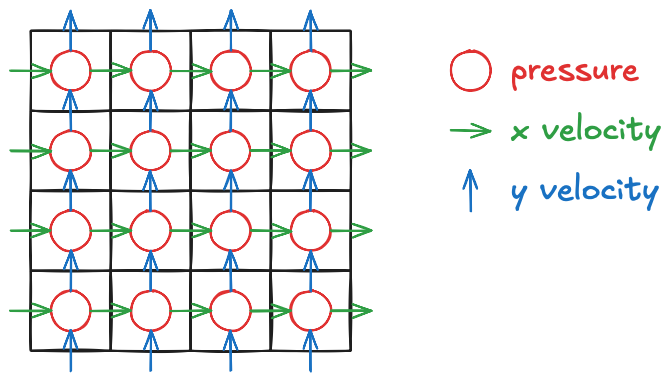

In [2]:
# Simulation domain size.
Sx, Sy = 64, 64
# Cell size.
dx = 1/2
# Wave speed.
c = 8
# Simulate time.
time_span = 8
# Delta time.
dt = dx / (c * pow(2, 0.5))
frames = int(time_span / dt)

print(f"Simulating {frames} physical frames.")

Simulating 181 physical frames.


In [3]:
# Render settings.
fps = 30
fdt = 1 / fps

In [4]:
# Init grid.
def init_grid():
    p = jnp.zeros((Sx, Sy))
    vx = jnp.zeros((Sx + 1, Sy))
    vy = jnp.zeros((Sx, Sy + 1))
    return (p, vx, vy)

p, vx, vy = init_grid()
p.shape, vx.shape, vy.shape

((64, 64), (65, 64), (64, 65))

# FDTD

1. Update cell velocity with pressure gradient.
2. Set velocity source.
3. Update pressure with velocity divergence.

## Velocity Source

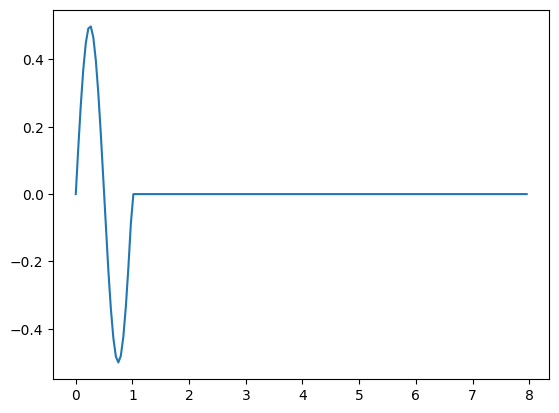

In [5]:
# Velocity function.
def v_func(t):
    return 1/2 * jnp.sin(2 * jnp.pi * t) * (t < 1)

# Plot pressure curve.
fig, ax = plt.subplots()
txs = jnp.linspace(0, (frames - 1)*dt, frames)
ax.plot(txs, v_func(txs))

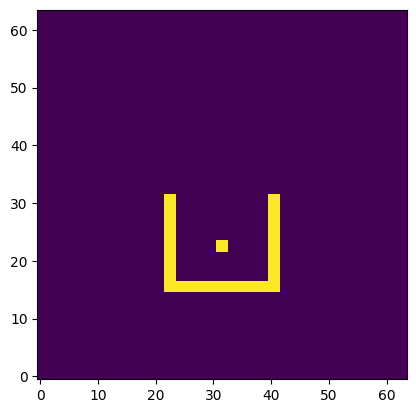

In [6]:
# Audio velocity mask and source.
v_mask = jnp.zeros((frames, Sx, Sy)).astype(bool)
v_source = jnp.zeros((frames, Sx, Sy, 2))
# Add source.
v_mask = v_mask.at[:, 31:33, 22:24].set(True)
v_source = v_source.at[:, 31:33, 22:24, 1].set(v_func(txs)[:, jnp.newaxis, jnp.newaxis])
# Add wall.
v_mask = v_mask.at[:, 40:42, 15:32].set(True)
v_mask = v_mask.at[:, 22:24, 15:32].set(True)
v_mask = v_mask.at[:, 22:42, 15:17].set(True)

fig, ax_mask = plt.subplots()
ax_mask.imshow(v_mask[0].T)
ax_mask.invert_yaxis()

In [7]:
fig, (ax_mask, ax_source) = plt.subplots(ncols=2)

f, w, h, _ = v_source.shape
v_source_vis = jnp.concatenate((v_source, jnp.zeros((f, w, h, 1))), axis=-1)
v_source_vis = (v_source_vis + 1) / 2
artists = []
fdt_counter = fdt
for frame in range(frames):
    if fdt_counter >= fdt:
        img_mask = ax_mask.imshow(v_mask[frame].T)
        ax_mask.invert_yaxis()
        img_source = ax_source.imshow(jnp.moveaxis(v_source_vis[frame], 0, 1))
        ax_source.invert_yaxis()
        artists.append([img_mask, img_source])
        fdt_counter -= fdt
    fdt_counter += dt

anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=int(fdt*1000))
plt.close()
HTML(anim.to_jshtml())

In [8]:
# Update source velocity.
def set_source_velocity(vx: jnp.ndarray, vy: jnp.ndarray, frame: int):
    vxi = vx[:-1, :].at[v_mask[frame]].set(v_source[frame, v_mask[frame], 0])
    vx = vx.at[:-1, :].set(vxi)
    vxi = vx[1:, :].at[v_mask[frame]].set(v_source[frame, v_mask[frame], 0])
    vx = vx.at[1:, :].set(vxi)
    vyi = vy[:, :-1].at[v_mask[frame]].set(v_source[frame, v_mask[frame], 1])
    vy = vy.at[:, :-1].set(vyi)
    vyi = vy[:, 1:].at[v_mask[frame]].set(v_source[frame, v_mask[frame], 1])
    vy = vy.at[:, 1:].set(vyi)
    return vx, vy

## Velocity

In [9]:
# Update velocity using pressure gradient.
def update_velocity(p: jnp.ndarray, vx: jnp.ndarray, vy: jnp.ndarray):
    vx = vx.at[1:-1, :].add(-(p[1:, :] - p[:-1, :]) / dx * dt)
    vy = vy.at[:, 1:-1].add(-(p[:, 1:] - p[:, :-1]) / dx * dt)
    return vx, vy

## Pressure

In [10]:
def update_pressure(p: jnp.ndarray, vx: jnp.ndarray, vy: jnp.ndarray):
    div_x = vx[1:, :] - vx[:-1, :]
    div_y = vy[:, 1:] - vy[:, :-1]
    div = div_x + div_y
    p = p - c**2 * div * dt
    return p

## Main Loop

In [11]:
def fdtd(grid, t, dt, frame):
    p, vx, vy = grid
    # Update velocity.
    vx, vy = update_velocity(p, vx, vy)
    # Set source velocity.
    vx, vy = set_source_velocity(vx, vy, frame)
    # Update pressure.
    p = update_pressure(p, vx, vy)
    return (p, vx, vy)

In [12]:
fig, ax = plt.subplots()

artists = []
p, vx, vy = init_grid()
t = 0
fdt_counter = fdt
for frame in range(frames):
    p, vx, vy = fdtd((p, vx, vy), t, dt, frame)
    t += dt
    if fdt_counter >= fdt:
        img = ax.imshow(p.T, vmin=-1, vmax=1, cmap="coolwarm")
        ax.invert_yaxis()
        artists.append([img])
        fdt_counter -= fdt
    fdt_counter += dt

anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=int(fdt * 1000))
plt.close()
HTML(anim.to_jshtml())

In [13]:
anim.save(filename="fdtd.gif", writer="pillow")